# Exploratory Analysis of the PVQD Dataset and Vocal Fold Image Segmentation Using the K-Means Algorithm

## Background

### Exploratory Analysis of the PVQD Dataset
The Perceptual Voice Qualities Database (PVQD) is an **unlabeled dataset** from the Consensus Auditory-Perceptual Evaluation of Voice (CAPE-V). Certain voice disorders are characterized by distinct perceptual rating combinations. For example:
- **Vocal fold paresis/paralysis:** High in breathiness due to a gap between the two vocal folds.
- **Nodules:** Hoarseness, particularly roughness.
- **Muscle tension dysphonia:** Increased strain in voice quality due to tense muscles in the larynx.

It would be interesting to see how a K-means algorithm classifies the voice samples in the dataset based on their ratings, to determine if certain patterns can be identified by the model.

### Vocal Fold Image Segmentation Using K-Means

The K-means algorithm can be employed for simple image segmentation based on colors. Fortunately, in most vocal fold images, the vocal folds, the intraglottal space, the supraglottic structures, and the endotracheal tube all display distinct colors. This makes it possible to achieve rough segmentation based on color, mimicking the results of semantic segmentation.

<p align="center">
  <img src="nodules_op_1.png" alt="Orginal" width="10%"/>
  <img src="nodules_op_marked.png" alt="Segmented Example" width="10%"/>
</p>

---
### The model- K-means Clustering 
K-means clustering is a straightforward  unsupervised learning algorithm. It works by partitioning a dataset into K distinct clusters based on the similarity of data points, effectively grouping data by minimizing the variance within each cluster. This technique is particularly useful for identifying inherent groupings within data.

The **silhouette score** is a metric used to determine the optimal number of clusters by measuring the mean silhouette coefficient across all data points. It provides a more accurate method than the elbow method for cluster determination. A score close to +1 means that the objects are well matched to their own cluster and poorly matched to neighboring clusters. This indicates that the clusters are distinct and clearly separated. A score of 0 indicates that the clusters are overlapping and not clearly distinguished. A score close to -1 means that the objects might have been assigned to the wrong cluster.

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
sns.set_theme()

In [3]:
df = pd.read_csv('Combined_PVQD_CAPEV.csv', delimiter=',')
df.dataframeName = 'Combined_PVQD_CAPEV.csv'
# Drop that last case no rating values 
df = df.dropna(subset=['Roughness', 'Pitch', 'Loudness', 'Breathiness', 'Strain'])

In [11]:
# Select and Scale the features
X = df[['Roughness', 'Pitch', 'Loudness', 'Breathiness', 'Strain']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Initialize the KMeans model with 5 clusters
kmeans = KMeans(n_clusters=2, random_state=42,n_init=10)
# Fit the model
kmeans.fit(X_scaled)

df['Cluster'] = kmeans.labels_

# Calculate the silhouette score
score = silhouette_score(X_scaled, kmeans.labels_)
print('Silhouette Score:', score)

Silhouette Score: 0.6127435947757309


Several `n_clusters` values were tested, and the one with the highest silhouette score corresponds to 2 clusters. Let's visualize it.


/Users/ruiqingfan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


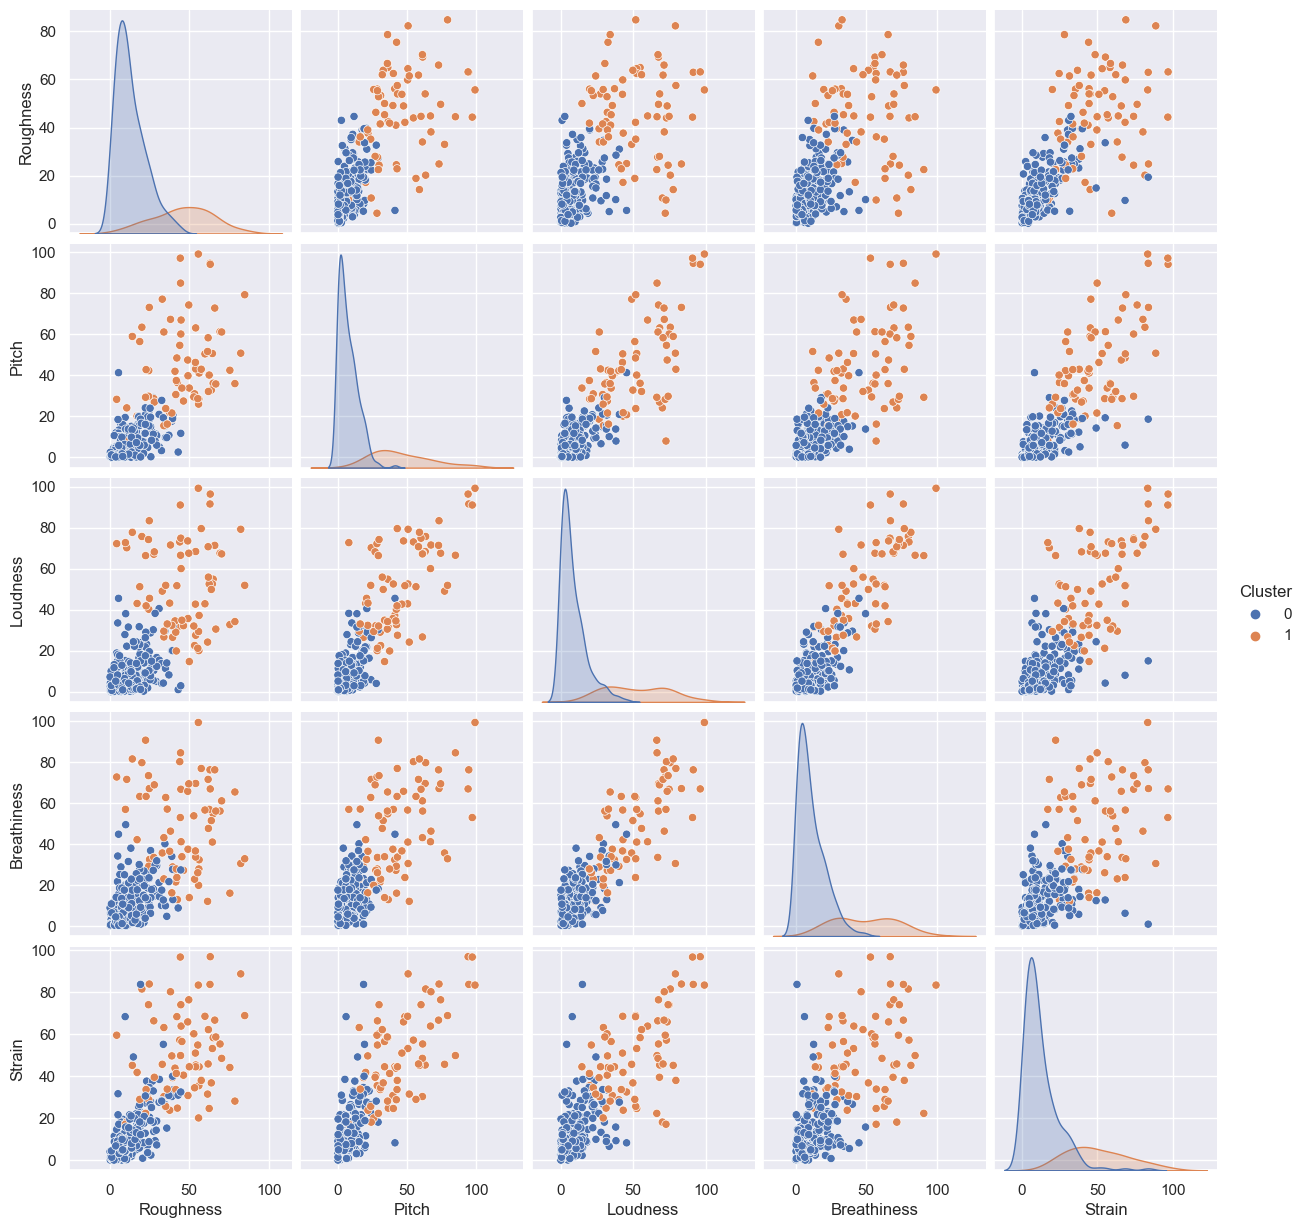

In [19]:
# Pairplot colored by cluster label
sns.pairplot(df[['Roughness', 'Pitch', 'Loudness', 'Breathiness', 'Strain', 'Cluster']], hue='Cluster')
plt.show()

### Observation
It's fascinating to see that the K-means clustering model successfully differentiated between mild-moderate and severe cases. This aligns with the **heteroscedasticity** observed in our linear regression model, which indicated significantly greater variability in the ratings of five characteristics (roughness, breathiness, loudness, strain, pitch) in severe cases compared to mild-moderate cases.

---

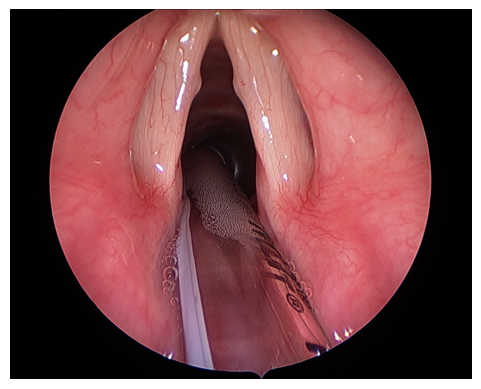

In [21]:
from matplotlib.image import imread
image = imread("nodules_op_1.png")
image.shape
plt.imshow(image)
plt.axis('off') 
plt.show()

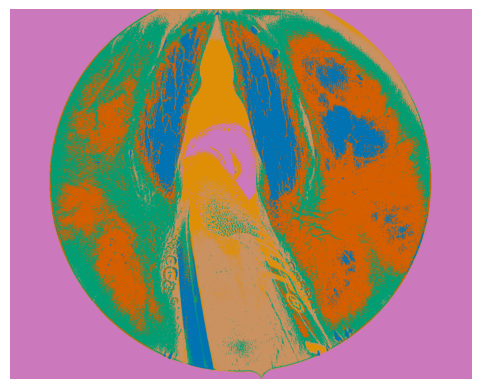

In [32]:
n=6
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=n,n_init=10).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

# Select a color palette from seaborn
palette = sns.color_palette("colorblind", n) 
new_colors = np.array(palette) * 255  # Convert from [0,1] to [0,255] RGB format
new_segmented_img = np.zeros((X.shape[0], 3))  # Create a new image array with the same number of pixels
for i in range(n):
    new_segmented_img[kmeans.labels_ == i] = new_colors[i]

# Reshape back to the original image shape
segmented_img = new_segmented_img.reshape(image.shape)

# Display the segmented image
plt.imshow(segmented_img.astype(np.uint8))
plt.axis('off')
plt.show()


### Observation
The segmentation was effective; the vocal fold area was successfully isolated based on color, though the right supraglottal area, having a similar color, was also included. Other structures were approximately identified as well.
